In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib as mpl
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df_all = pd.read_csv('전체데이터통합3.csv', encoding='cp949')

In [76]:
df_all.head()

,base_date,city,emd_nm,0여성notvisit,0여성visit,0남성notvisit,0남성visit,10여성notvisit,10여성visit,10남성notvisit,...,평균 상대습도(%),평균 현지기압(hPa),합계 일사량(MJ/m2),일 최심신적설(cm),평균 전운량(1/10),내국인거주남성,외국인거주남성,내국인거주여성,외국인거주여성,배출량
0,2018-01-01,서귀포시,남원읍,11030.2331,9791.3235,11498.2617,10650.5811,13324.2924,10954.4914,15372.8110,...,58.9,1020.3,0.00,0.0,0.0,9806,428,9306,200,1239600
1,2018-01-01,서귀포시,대륜동,17647.5285,10160.5833,15216.9486,10298.1857,14152.0528,11361.8229,12541.6031,...,58.9,1020.3,0.00,0.0,0.0,6836,83,6637,95,1717700
2,2018-01-01,서귀포시,대정읍,12538.2881,7792.5662,14360.4369,6043.2109,16053.7231,8710.5446,19530.3550,...,58.4,1018.5,7.72,0.0,0.0,10360,841,10725,677,1264950
3,2018-01-01,서귀포시,대천동,10539.1926,7307.2766,10214.4234,7677.3523,7645.1222,8157.7877,7511.4389,...,58.9,1020.3,0.00,0.0,0.0,6685,107,6475,137,1765600
4,2018-01-01,서귀포시,동홍동,20141.3526,7741.1595,22060.7555,8331.2173,28043.7082,8607.6880,31639.5584,...,58.9,1020.3,0.00,0.0,0.0,11124,624,11569,642,4165050


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 모델 평가
def model_train_test_eval(model, df_tuple):
    df = df_tuple[0]
    df_name = df_tuple[1]
    X = df.iloc[:, 3:-1]
    y = df.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f'### {df_name} ###')
    print(f'RMSE : {rmse:.4f}')
    print(f'MAE : {mae:.4f}')
    print(f'R2 : {r2:.4f}')

# Feature Importance 그래프
def plot_ftr_importance(i, model, df_tuple, fig, ax, top=20, save=False):
    df = df_tuple[0]
    df_name = df_tuple[1]

    ftr_importances_values_model = model.feature_importances_
    ftr_importances_model = pd.Series(ftr_importances_values_model, index=df.iloc[:, 3:-1].columns)
    ftr_top20_model = ftr_importances_model.sort_values(ascending=False)[:top]
    
    if model.__class__.__name__ == 'LGBMRegressor':
        sum_ftr_importances = sum(ftr_importances_model)
        ftr_top20_model /= sum_ftr_importances
    
    if len(ftr_importances_model.index) < 20:
        top = len(ftr_importances_model.index)
    
    ax.set_title(f'{df_name}의 {model.__class__.__name__} 상위 {top}개 Feature Importances')
    sns.barplot(x=ftr_top20_model, y=ftr_top20_model.index, ax=ax)
    if save:
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(f'{df_name}.png', bbox_inches=extent.expanded(1.35, 1.2))

In [25]:
# 학습부터 plot까지 모든 과정 압축
# model_name : 'XGBoost', 'LGBM', 'RF'
# params : {'param1':value1, 'param2':value2, ...}
# df_list : (data_frame, data_name)
# ncols : the number of plot columns
def train_to_plot(model_name, params, df_list, ncols=1, save=False):
    nrows = (len(df_list)+1) // ncols
    if len(df_list) == 1:
        nrows = 1
    fig, axs = plt.subplots(figsize=(12*ncols, 10*nrows), ncols=ncols, nrows=nrows)
    
    for i, df_tuple in enumerate(df_list):
        
        # 모델 선택
        if model_name == 'XGBoost':
            model = XGBRegressor(**params)
        elif model_name == 'LGBM':
            model = LGBMRegressor(**params)
        elif model_name == 'RF':
            model = RandomForestRegressor(**params)
        else:
            print('NONE of XGBoost, LGBM or RF')
            return
        
        # plot 위치 지정
        row = i//2
        col = i%2
        if nrows > 1 and ncols > 1:
            ax = axs[row, col]
        elif (nrows == 1 or ncols == 1) and (nrows * ncols != 1):
            ax = axs[i]
        else:
            ax = axs
            
        model_train_test_eval(model, df_tuple)
        plot_ftr_importance(i, model, df_tuple, fig, ax, top=20, save=save)
        print()
    plt.show()

In [8]:
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor

# 전체 데이터

In [9]:
df_resd_all_list = [(df_all, '유동인구와 거주인구가 함께 있는 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 유동인구와 거주인구가 함께 있는 데이터 ###
RMSE : 269942.0298
MAE : 168494.6247
R2 : 0.9809



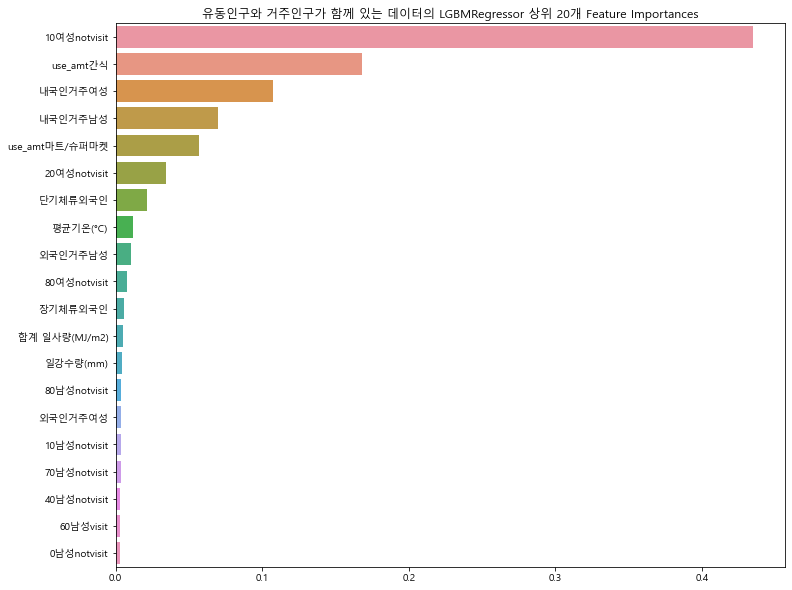

Wall time: 2.14 s


In [13]:
%%time
train_to_plot('LGBM', params, df_resd_all_list, ncols=1)

## 연도별

In [14]:
df_all181 = df_all[(df_all['base_date']<'2018-07')]
df_all182 = df_all[(df_all['base_date']>'2018-07') & (df_all['base_date']<'2019')]
df_all191 = df_all[(df_all['base_date']>'2019') & (df_all['base_date']<'2019-07')]
df_all192 = df_all[(df_all['base_date']>'2019-07') & (df_all['base_date']<'2020')]
df_all201 = df_all[(df_all['base_date']>'2020') & (df_all['base_date']<'2020-07')]
df_all202 = df_all[(df_all['base_date']>'2020-07') & (df_all['base_date']<'2021')]
df_all211 = df_all[(df_all['base_date']>'2021')]

In [15]:
df_all_year_list = [(df_all181, '18년 상반기 전체 데이터'), (df_all182, '18년 하반기 전체 데이터'), (df_all191, '19년 상반기 전체 데이터'), (df_all192, '19년 하반기 전체 데이터'),
          (df_all201, '20년 상반기 전체 데이터'), (df_all202, '20년 하반기 전체 데이터'), (df_all201, '21년 상반기 전체 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 18년 상반기 전체 데이터 ###
RMSE : 241283.3417
MAE : 146072.7102
R2 : 0.9867

### 18년 하반기 전체 데이터 ###
RMSE : 228706.6061
MAE : 139251.7444
R2 : 0.9895

### 19년 상반기 전체 데이터 ###
RMSE : 233615.1275
MAE : 155295.8783
R2 : 0.9862

### 19년 하반기 전체 데이터 ###
RMSE : 267925.2217
MAE : 162824.0504
R2 : 0.9805

### 20년 상반기 전체 데이터 ###
RMSE : 314408.3421
MAE : 176275.6370
R2 : 0.9703

### 20년 하반기 전체 데이터 ###
RMSE : 271547.2861
MAE : 173528.3997
R2 : 0.9803

### 21년 상반기 전체 데이터 ###
RMSE : 314408.3421
MAE : 176275.6370
R2 : 0.9703



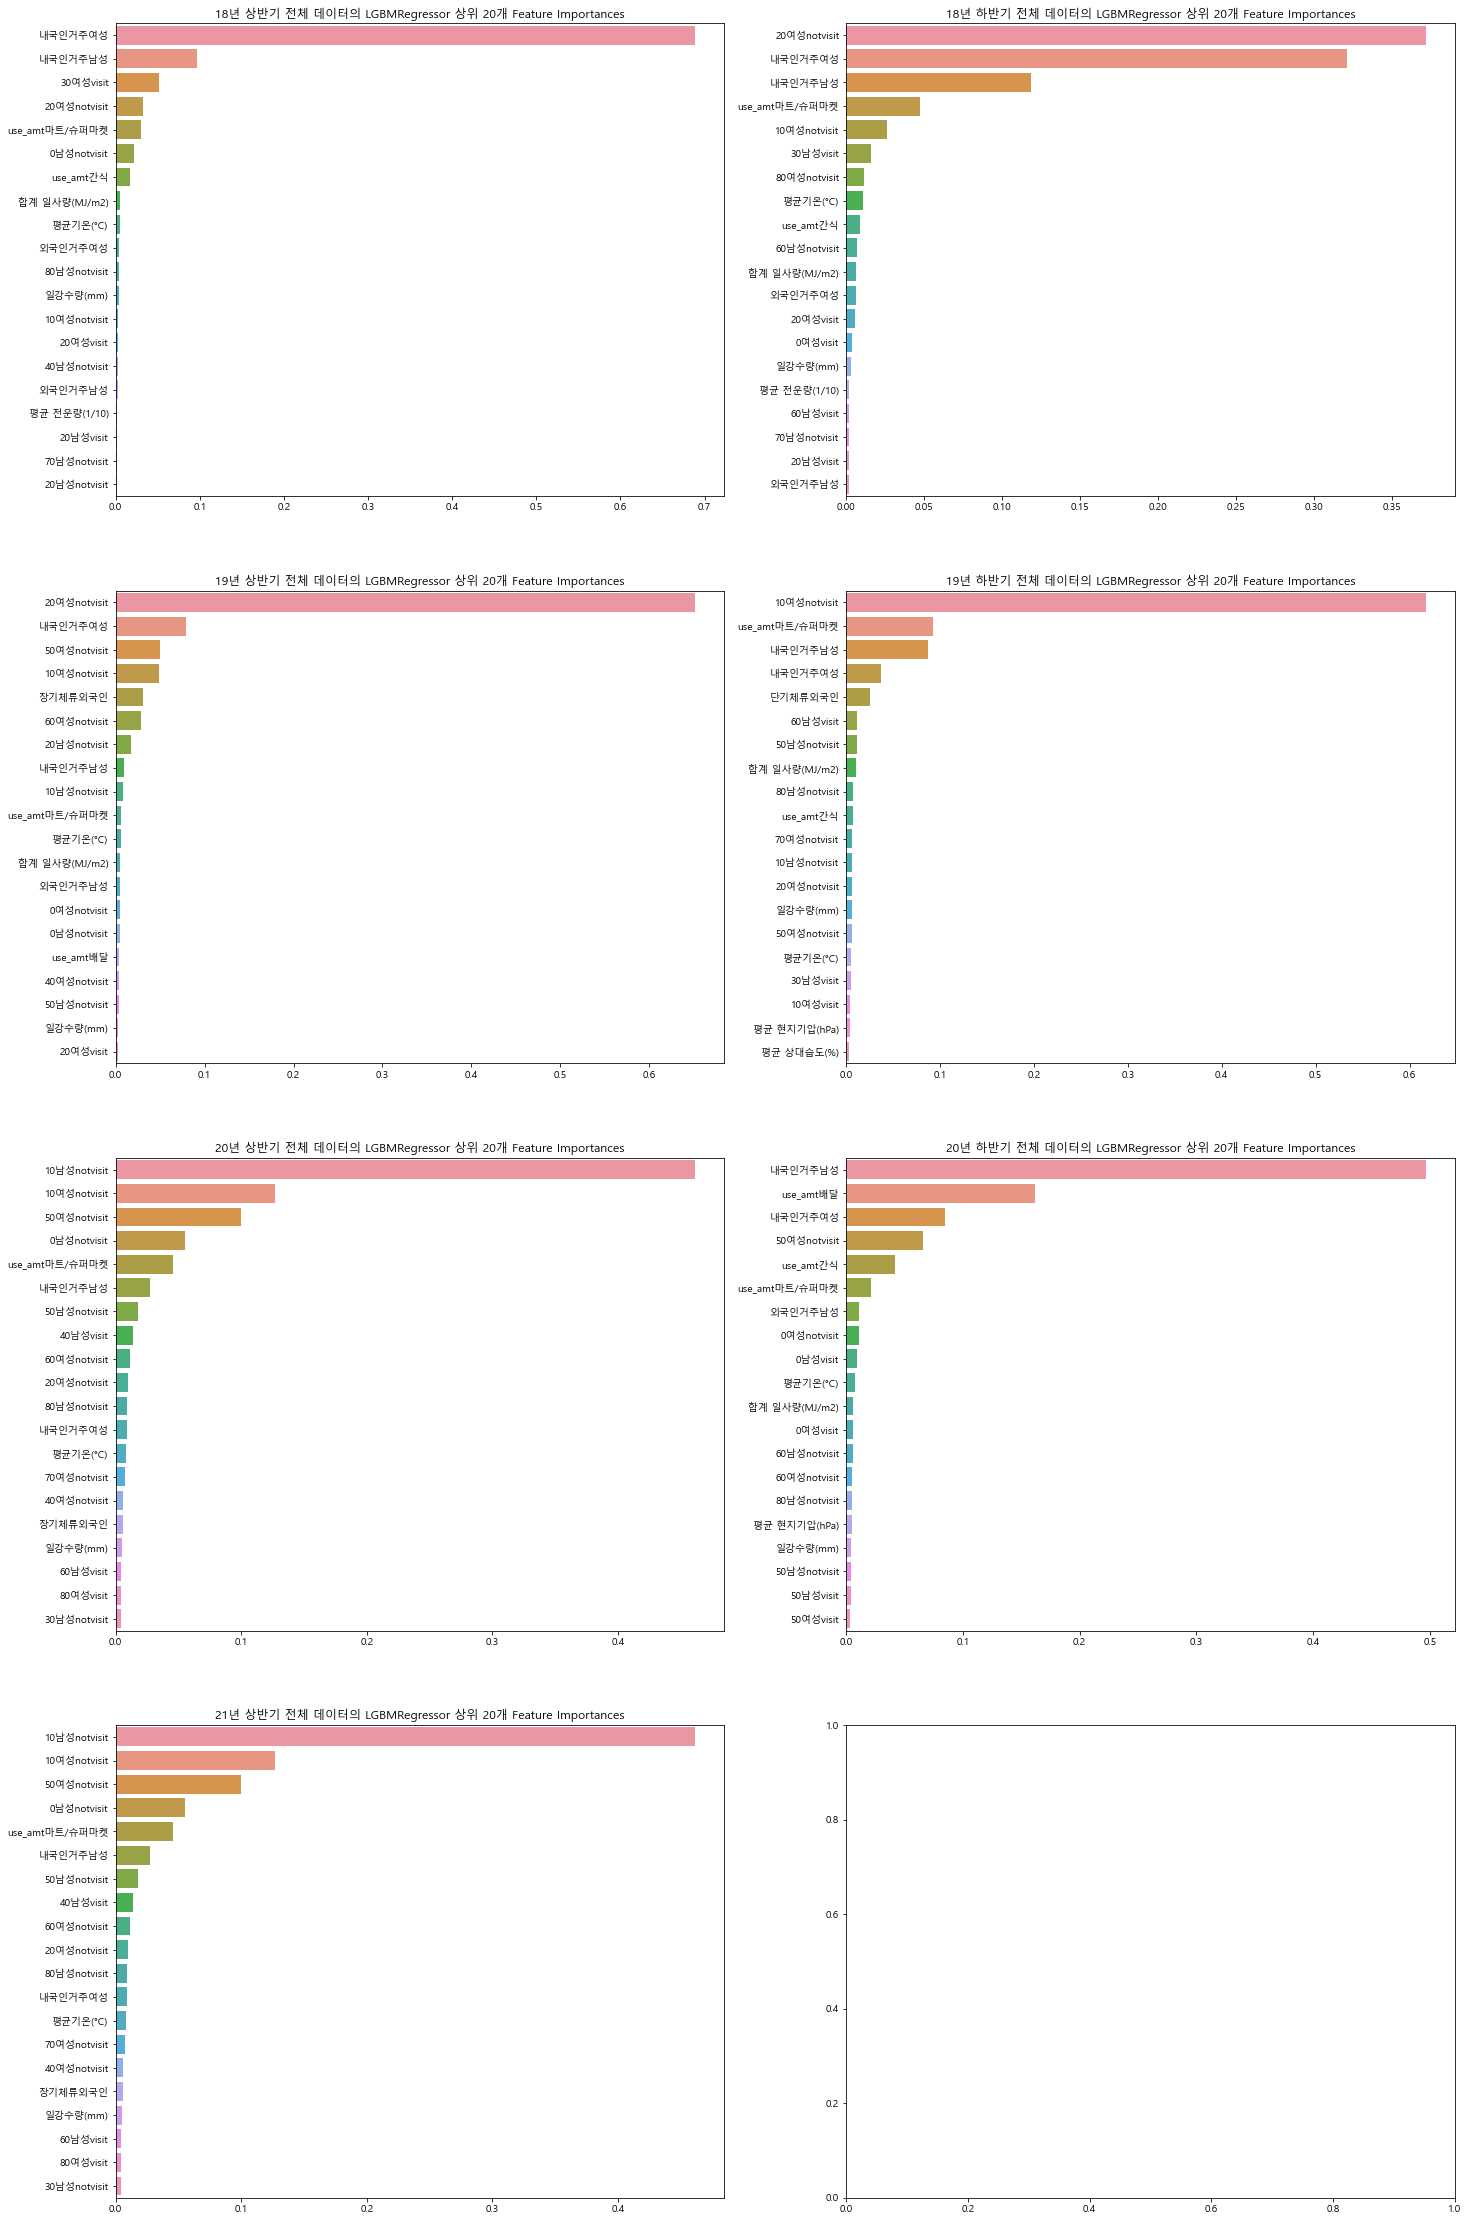

Wall time: 12.7 s


In [34]:
%%time
train_to_plot('LGBM', params, df_all_year_list, ncols=2)

# 인구 feature 제외

In [42]:
df_notpop = df_all.iloc[:, 38:]
df_notpop = df_notpop.drop(columns=['내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성'])

In [43]:
df_notpop.columns

Index(['80남성visit', '장기체류외국인', '단기체류외국인', 'dayoff', 'use_amt배달', 'use_amt식품',
       'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)',
       '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)',
       '평균 전운량(1/10)', '배출량'],
      dtype='object')

In [45]:
df_pop_only = df_all.drop(columns=df_notpop.iloc[:, 3:-1].columns)
df_pop_only.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [46]:
df_pop_list = [(df_notpop, '인구 Feature를 제외한 데이터'), (df_pop_only, '인구 Feature만 있는 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 인구 Feature를 제외한 데이터 ###
RMSE : 520627.4110
MAE : 355562.8298
R2 : 0.9289

### 인구 Feature만 있는 데이터 ###
RMSE : 380231.0163
MAE : 221241.9889
R2 : 0.9621



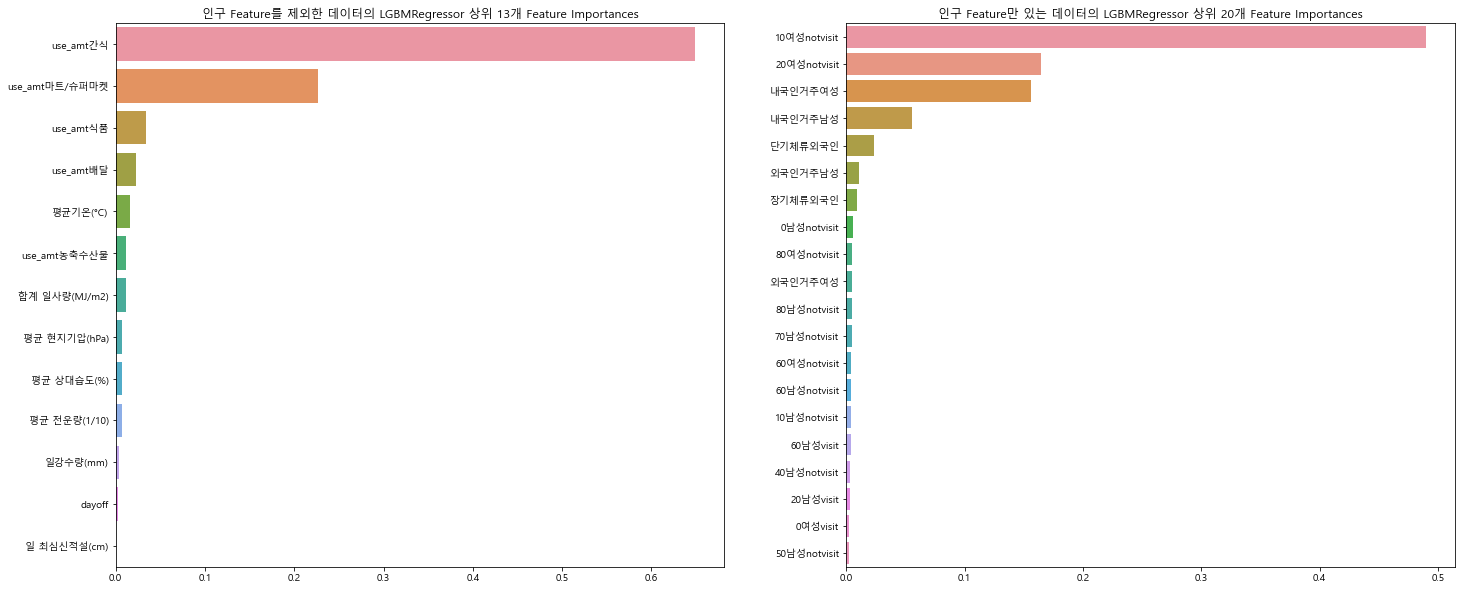

Wall time: 3.07 s


In [47]:
%%time
train_to_plot('LGBM', params, df_pop_list, ncols=2)

## 연도별

In [15]:
df_notpop['base_date'] = df_all['base_date']

In [16]:
df_notpop181 = df_notpop[(df_notpop['base_date']<'2018-07')].drop(columns=['base_date'])
df_notpop182 = df_notpop[(df_notpop['base_date']>'2018-07') & (df_notpop['base_date']<'2019')].drop(columns=['base_date'])
df_notpop191 = df_notpop[(df_notpop['base_date']>'2019') & (df_notpop['base_date']<'2019-07')].drop(columns=['base_date'])
df_notpop192 = df_notpop[(df_notpop['base_date']>'2019-07') & (df_notpop['base_date']<'2020')].drop(columns=['base_date'])
df_notpop201 = df_notpop[(df_notpop['base_date']>'2020') & (df_notpop['base_date']<'2020-07')].drop(columns=['base_date'])
df_notpop202 = df_notpop[(df_notpop['base_date']>'2020-07') & (df_notpop['base_date']<'2021')].drop(columns=['base_date'])
df_notpop211 = df_notpop[(df_notpop['base_date']>'2021')].drop(columns=['base_date'])

In [17]:
df_notpop_year_list = [(df_notpop181, '18년 상반기 인구 제외 데이터'), (df_notpop182, '18년 하반기 인구 제외 데이터'), (df_notpop191, '19년 상반기 인구 제외 데이터'), (df_notpop192, '19년 하반기 인구 제외 데이터'),
          (df_notpop201, '20년 상반기 인구 제외 데이터'), (df_notpop202, '20년 하반기 인구 제외 데이터'), (df_notpop201, '21년 상반기 인구 제외 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 18년 상반기 인구 제외 데이터 ###
RMSE : 478996.3541
MAE : 330929.5023
R2 : 0.9474

### 18년 하반기 인구 제외 데이터 ###
RMSE : 519971.4247
MAE : 339656.5757
R2 : 0.9455

### 19년 상반기 인구 제외 데이터 ###
RMSE : 479179.5395
MAE : 322482.5173
R2 : 0.9421

### 19년 하반기 인구 제외 데이터 ###
RMSE : 554257.8692
MAE : 382577.5793
R2 : 0.9165

### 20년 상반기 인구 제외 데이터 ###
RMSE : 543000.2470
MAE : 372669.5792
R2 : 0.9113

### 20년 하반기 인구 제외 데이터 ###
RMSE : 457667.5950
MAE : 340881.1049
R2 : 0.9440

### 21년 상반기 인구 제외 데이터 ###
RMSE : 543000.2470
MAE : 372669.5792
R2 : 0.9113



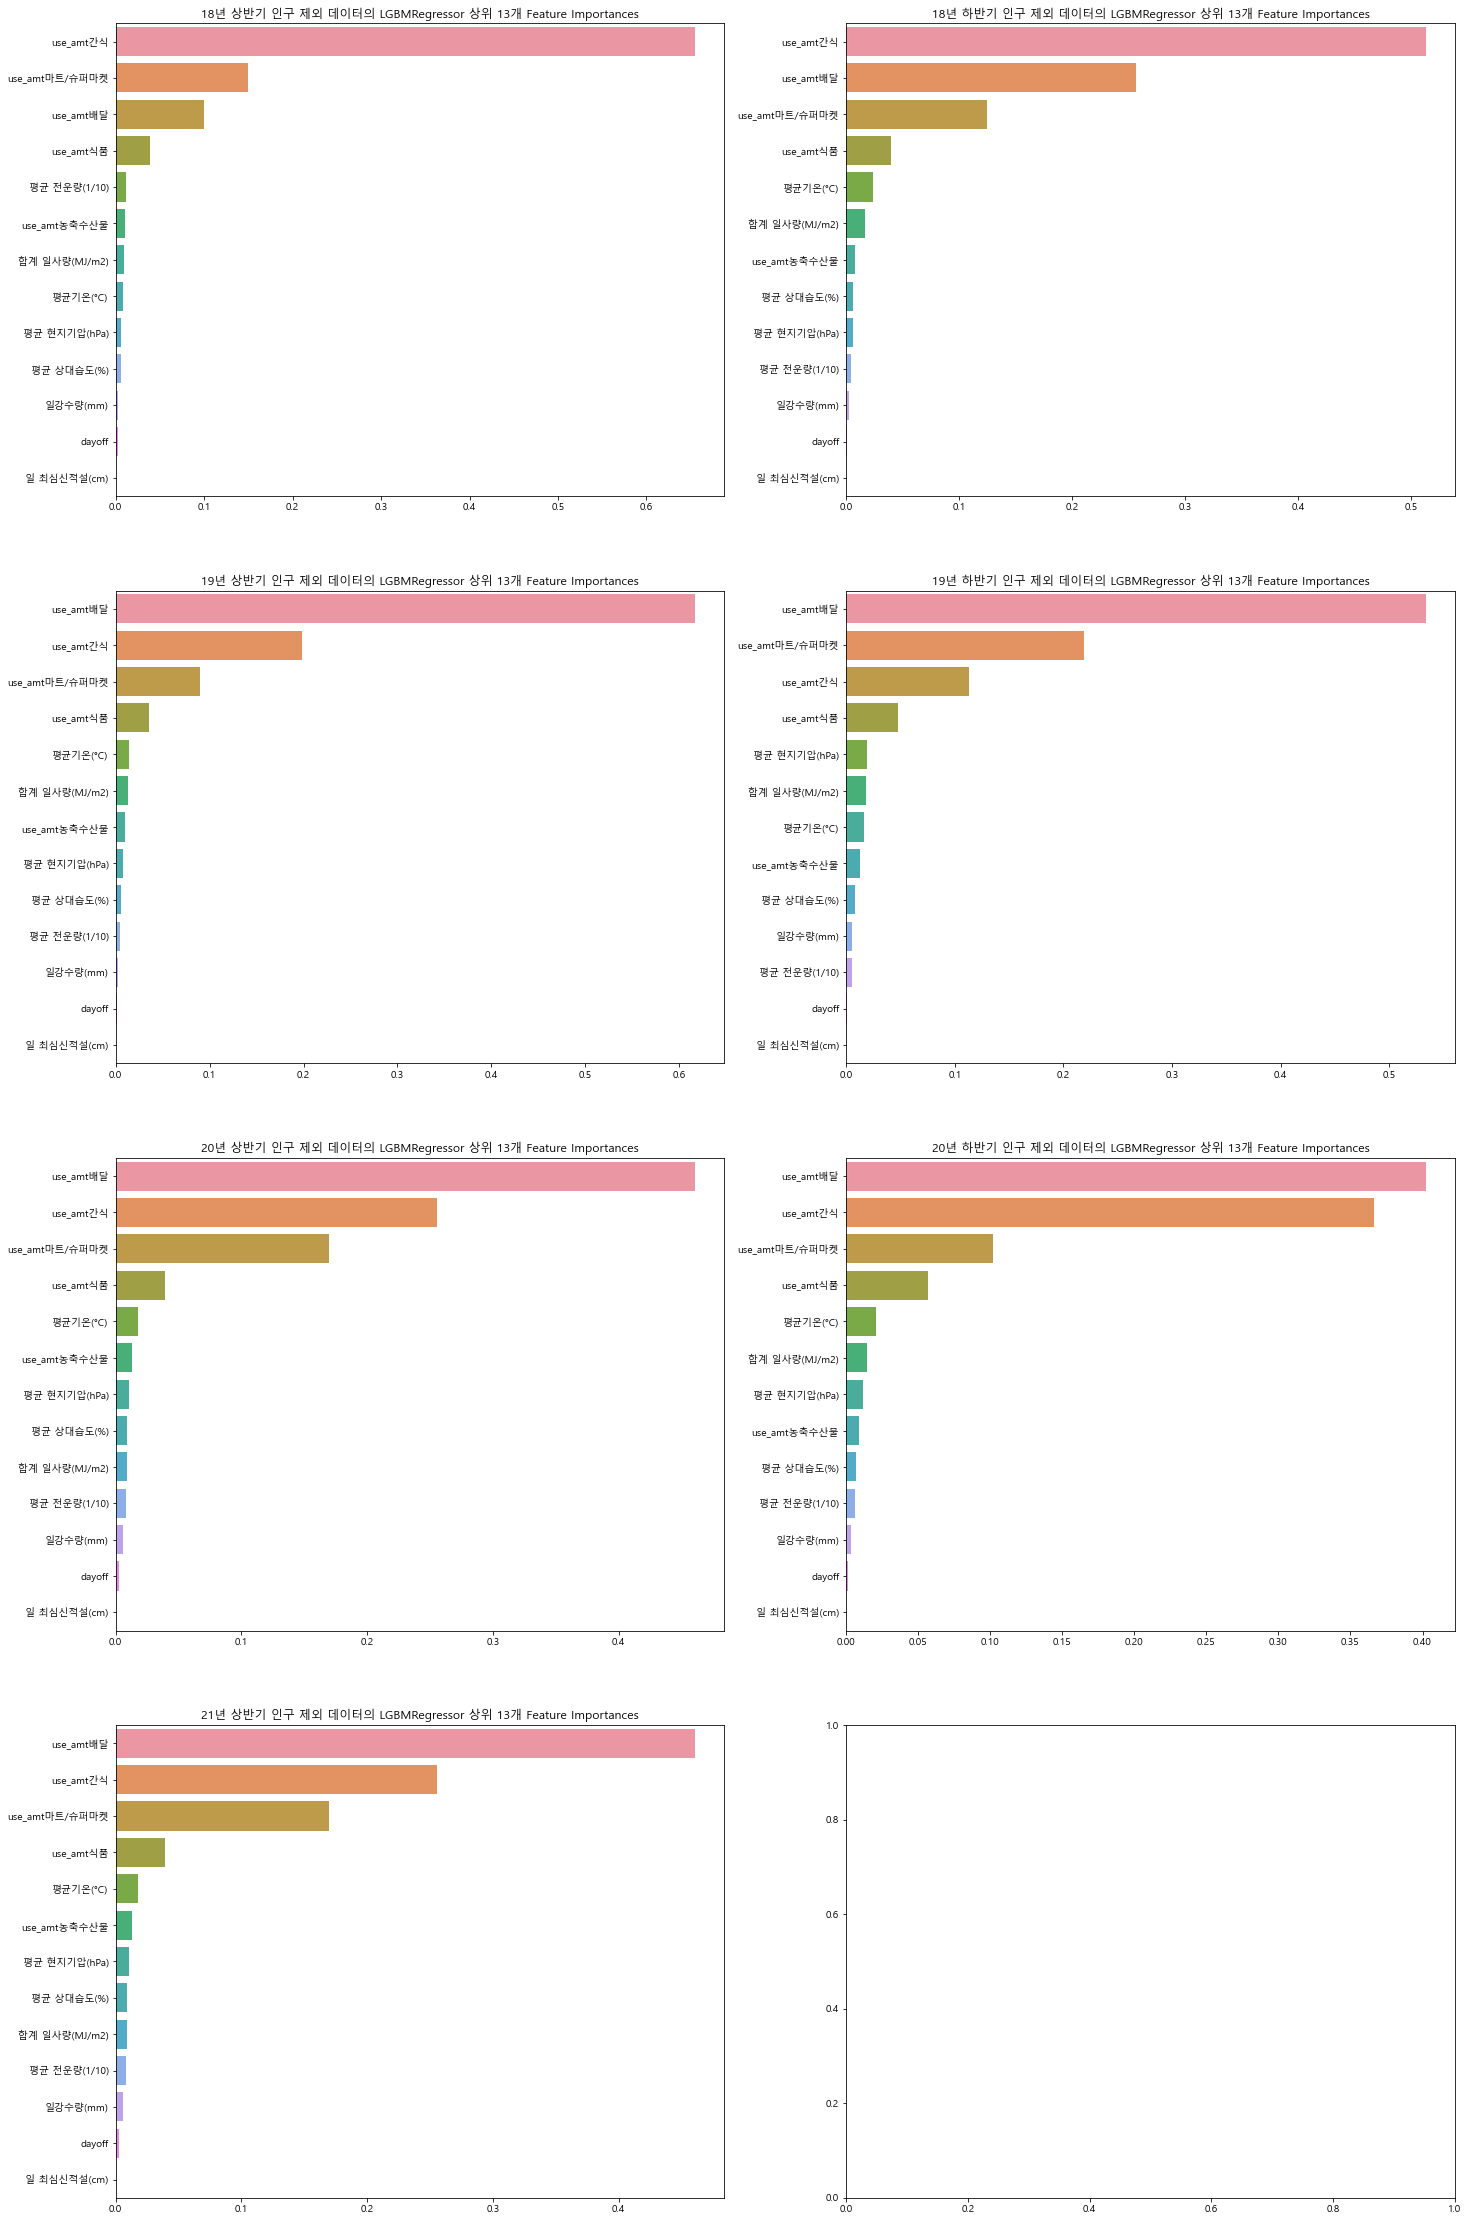

Wall time: 6.89 s


In [18]:
%%time
train_to_plot('LGBM', params, df_notpop_year_list, ncols=2)

# 유동 인구 제외 & 거주 인구만

In [37]:
df_resd = df_all.drop(columns=df_all.iloc[:, 3:41].columns)
df_resd.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', 'use_amt배달', 'use_amt식품',
       'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)',
       '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)',
       '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [20]:
df_resd_only = df_resd.drop(columns=df_resd.iloc[:, 3:-5].columns)
df_resd_only.columns

Index(['base_date', 'city', 'emd_nm', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [21]:
df_resd_list = [(df_resd, '거주인구 데이터'), (df_resd_only, '거주인구로만 이루어진 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 거주인구 데이터 ###
RMSE : 255081.6898
MAE : 163309.8105
R2 : 0.9829

### 거주인구로만 이루어진 데이터 ###
RMSE : 394878.2916
MAE : 221493.3607
R2 : 0.9591



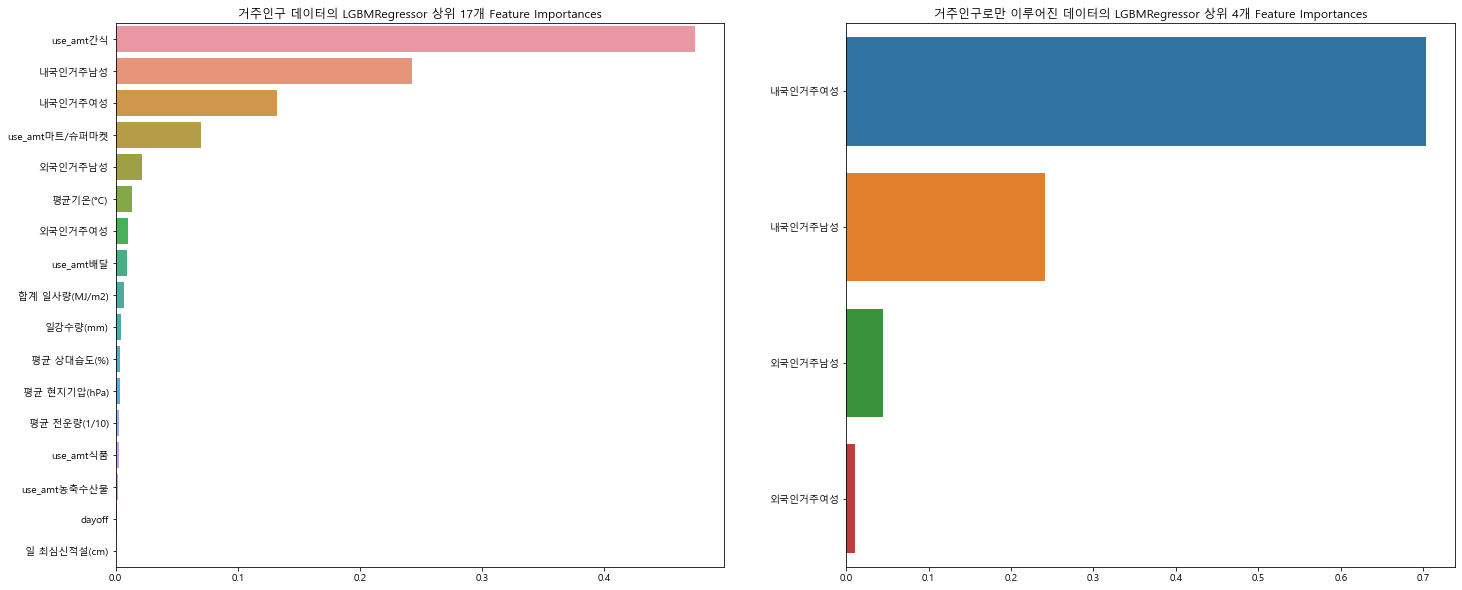

Wall time: 2.81 s


In [22]:
%%time
train_to_plot('LGBM', params, df_resd_list, ncols=2)

## 연도별

In [38]:
df_resd181 = df_resd[(df_resd['base_date']<'2018-07')]
df_resd182 = df_resd[(df_resd['base_date']>'2018-07') & (df_resd['base_date']<'2019')]
df_resd191 = df_resd[(df_resd['base_date']>'2019') & (df_resd['base_date']<'2019-07')]
df_resd192 = df_resd[(df_resd['base_date']>'2019-07') & (df_resd['base_date']<'2020')]
df_resd201 = df_resd[(df_resd['base_date']>'2020') & (df_resd['base_date']<'2020-07')]
df_resd202 = df_resd[(df_resd['base_date']>'2020-07') & (df_resd['base_date']<'2021')]
df_resd211 = df_resd[(df_resd['base_date']>'2021')]

In [39]:
df_resd_year_list = [(df_resd181, '18년 상반기 거주인구 데이터'), (df_resd182, '18년 하반기 거주인구 데이터'), (df_resd191, '19년 상반기 거주인구 데이터'), (df_resd192, '19년 하반기 거주인구 데이터'),
          (df_resd201, '20년 상반기 거주인구 데이터'), (df_resd202, '20년 하반기 거주인구 데이터'), (df_resd201, '21년 상반기 거주인구 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 18년 상반기 거주인구 데이터 ###
RMSE : 212366.5946
MAE : 136746.7423
R2 : 0.9897

### 18년 하반기 거주인구 데이터 ###
RMSE : 201505.8240
MAE : 135450.3188
R2 : 0.9918

### 19년 상반기 거주인구 데이터 ###
RMSE : 250906.0706
MAE : 157330.9654
R2 : 0.9841

### 19년 하반기 거주인구 데이터 ###
RMSE : 259068.0366
MAE : 163707.5647
R2 : 0.9818

### 20년 상반기 거주인구 데이터 ###
RMSE : 312509.0702
MAE : 177544.9888
R2 : 0.9706

### 20년 하반기 거주인구 데이터 ###
RMSE : 258509.2178
MAE : 170388.6646
R2 : 0.9821

### 21년 상반기 거주인구 데이터 ###
RMSE : 312509.0702
MAE : 177544.9888
R2 : 0.9706



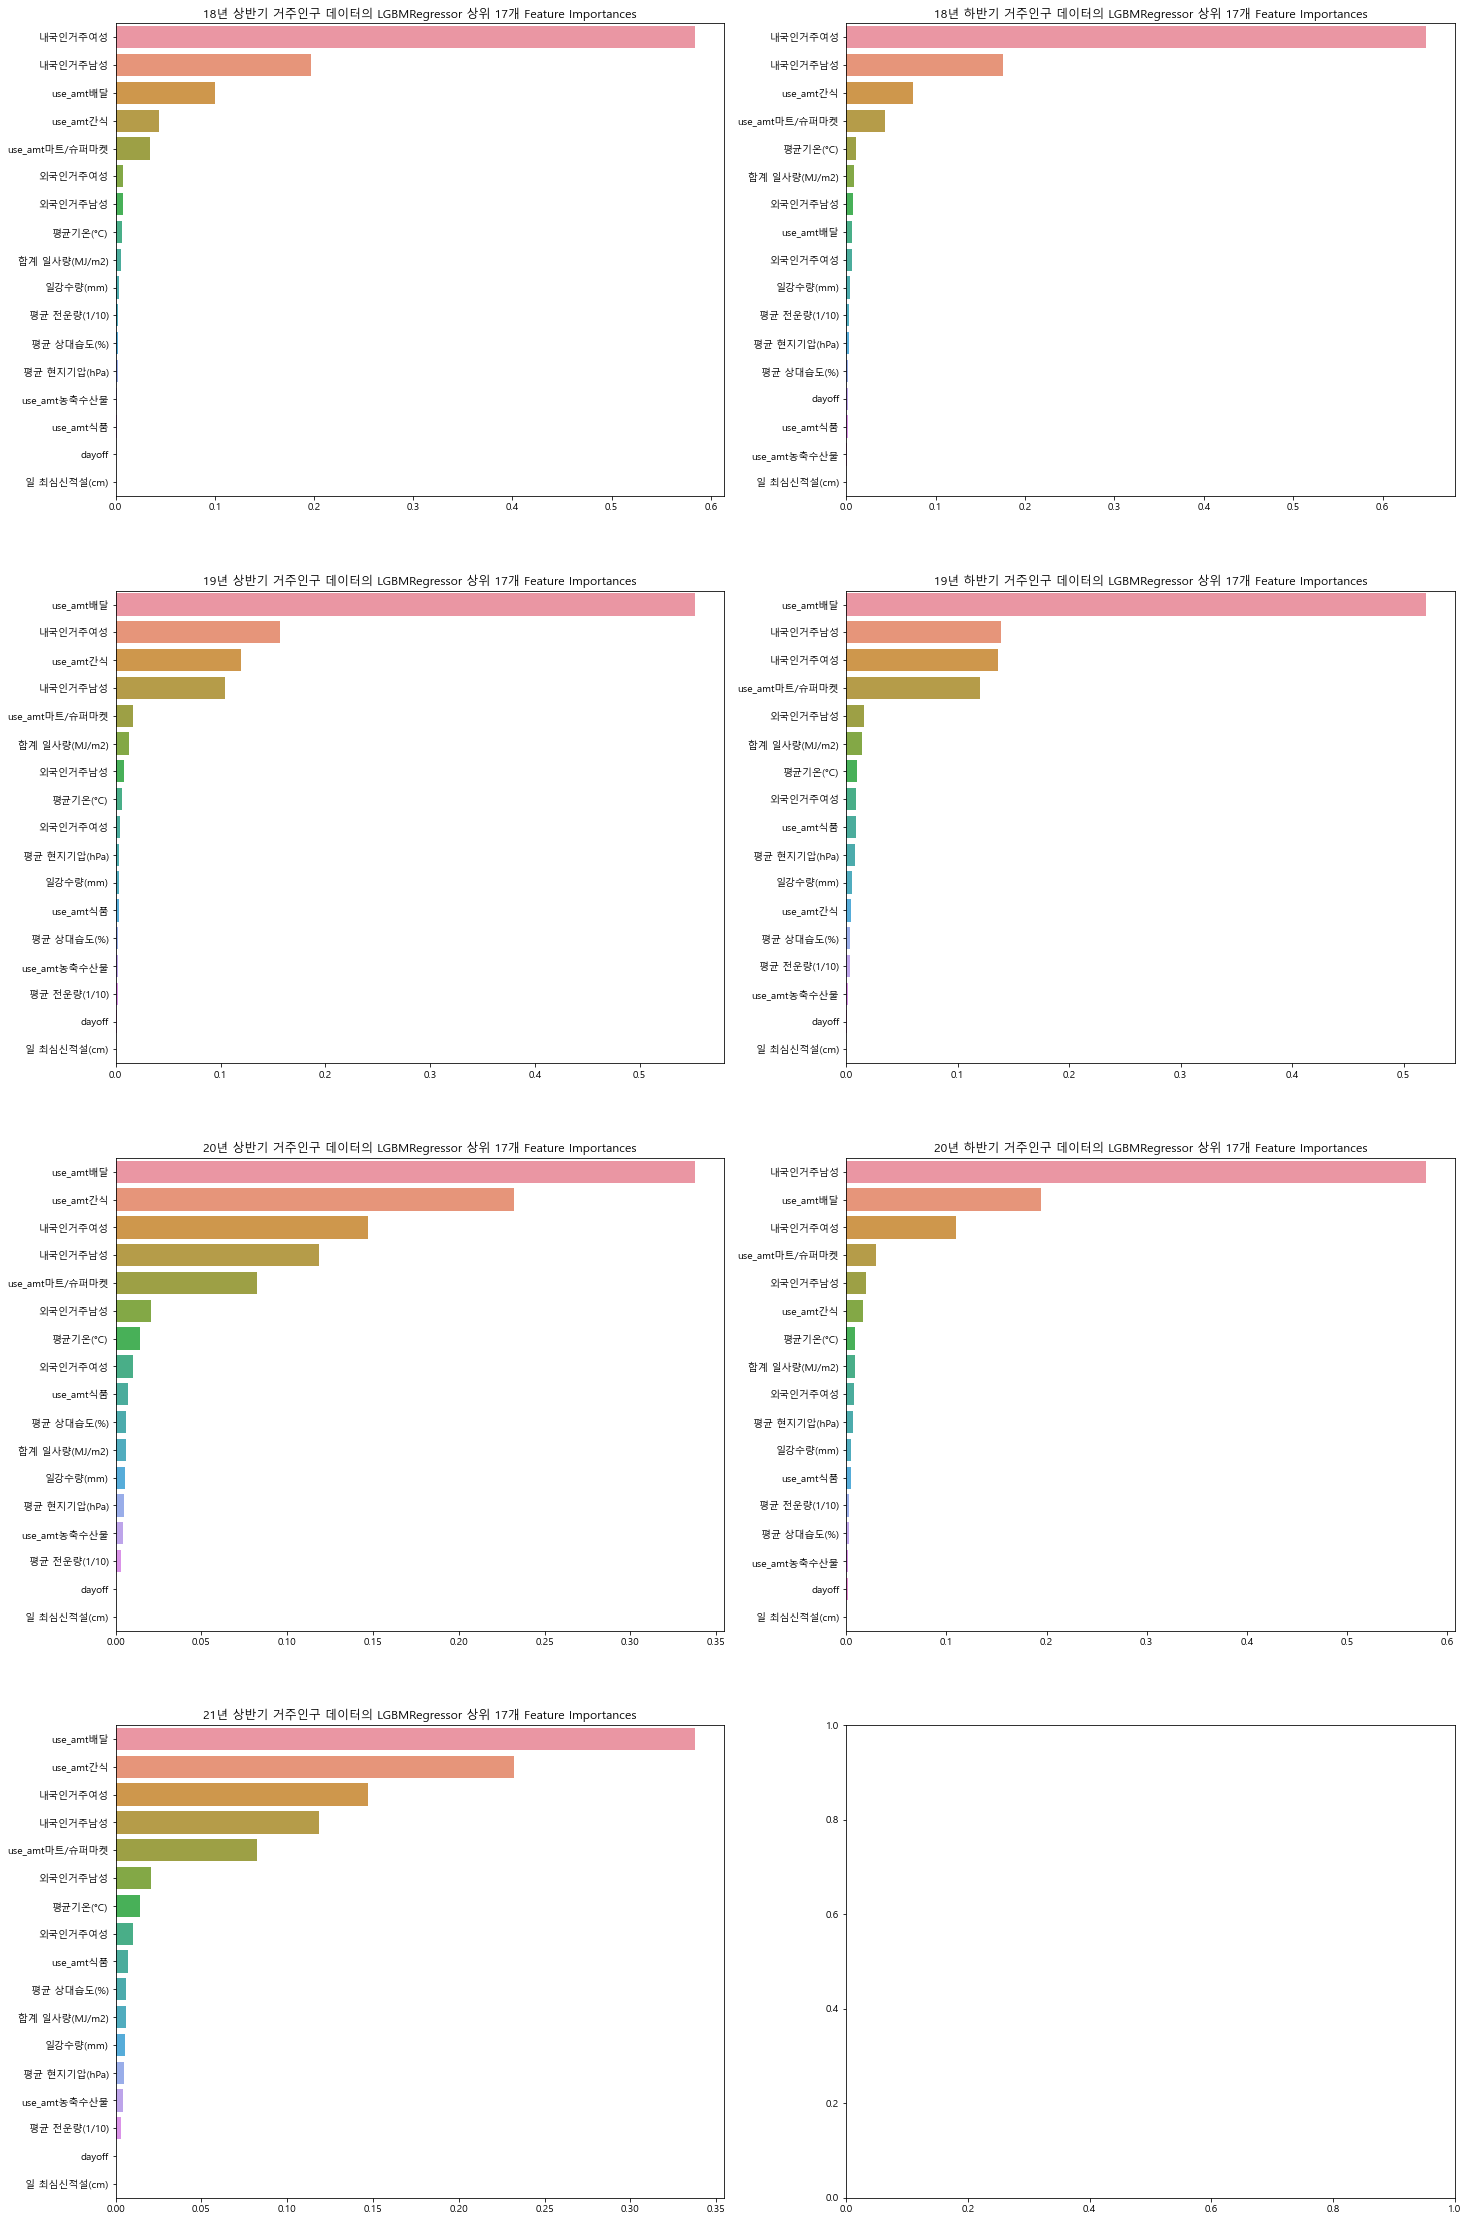

Wall time: 8.3 s


In [40]:
%%time
train_to_plot('LGBM', params, df_resd_year_list, ncols=2)

# 유동 인구 notvisit 제외 & visit만

In [27]:
df_visit_resd = df_all.iloc[:, [0,1, 2] + [2*i for i in range(2, 20)]+[i for i in range(41, 59)]]
df_visit_resd.columns

Index(['base_date', 'city', 'emd_nm', '0여성visit', '0남성visit', '10여성visit',
       '10남성visit', '20여성visit', '20남성visit', '30여성visit', '30남성visit',
       '40여성visit', '40남성visit', '50여성visit', '50남성visit', '60여성visit',
       '60남성visit', '70여성visit', '70남성visit', '80여성visit', '80남성visit',
       'dayoff', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓',
       'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)',
       '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성',
       '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [28]:
df_visit = df_all.iloc[:, [0, 1, 2] + [2*i for i in range(2, 20)]+[58]]
df_visit.columns

Index(['base_date', 'city', 'emd_nm', '0여성visit', '0남성visit', '10여성visit',
       '10남성visit', '20여성visit', '20남성visit', '30여성visit', '30남성visit',
       '40여성visit', '40남성visit', '50여성visit', '50남성visit', '60여성visit',
       '60남성visit', '70여성visit', '70남성visit', '80여성visit', '80남성visit', '배출량'],
      dtype='object')

In [29]:
df_visit_list = [(df_visit_resd, '거주인구와 방문객 데이터'), (df_visit, '방문객으로만 이루어진 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 거주인구와 방문객 데이터 ###
RMSE : 272967.9699
MAE : 173189.9495
R2 : 0.9804

### 방문객으로만 이루어진 데이터 ###
RMSE : 637116.7589
MAE : 416875.0941
R2 : 0.8935



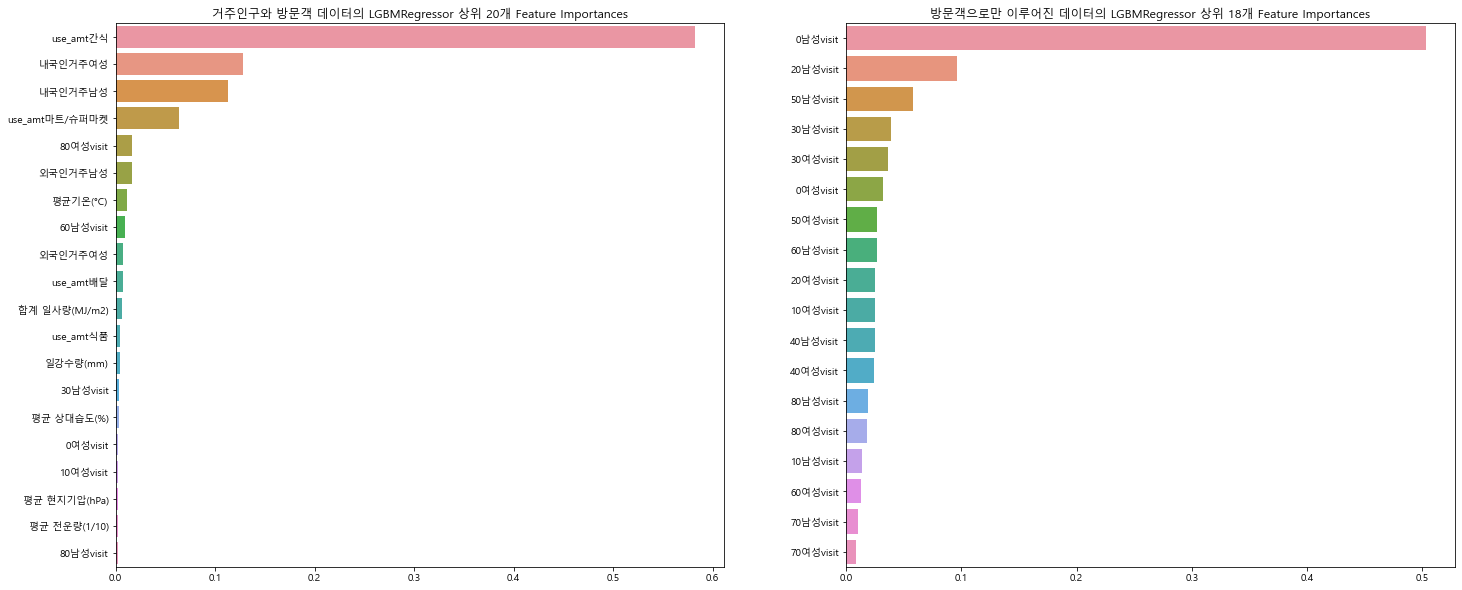

Wall time: 3.17 s


In [30]:
%%time
train_to_plot('LGBM', params, df_visit_list, ncols=2)

## 거주 인구 제외 & 유동 인구만

In [69]:
df_float = df_all.drop(columns=df_all.iloc[:, -5:-1].columns)
df_float.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)', '배출량'],
      dtype='object')

In [35]:
df_float_only = df_all.iloc[:, [i for i in range(41)]+[-1]]
df_float_only.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', '배출량'],
      dtype='object')

In [36]:
df_float_list = [(df_float, '유동인구 데이터'), (df_float_only, '유동인구만으로 이루어진 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 유동인구 데이터 ###
RMSE : 282677.3083
MAE : 179068.5106
R2 : 0.9790

### 유동인구만으로 이루어진 데이터 ###
RMSE : 395150.2359
MAE : 236176.2607
R2 : 0.9590



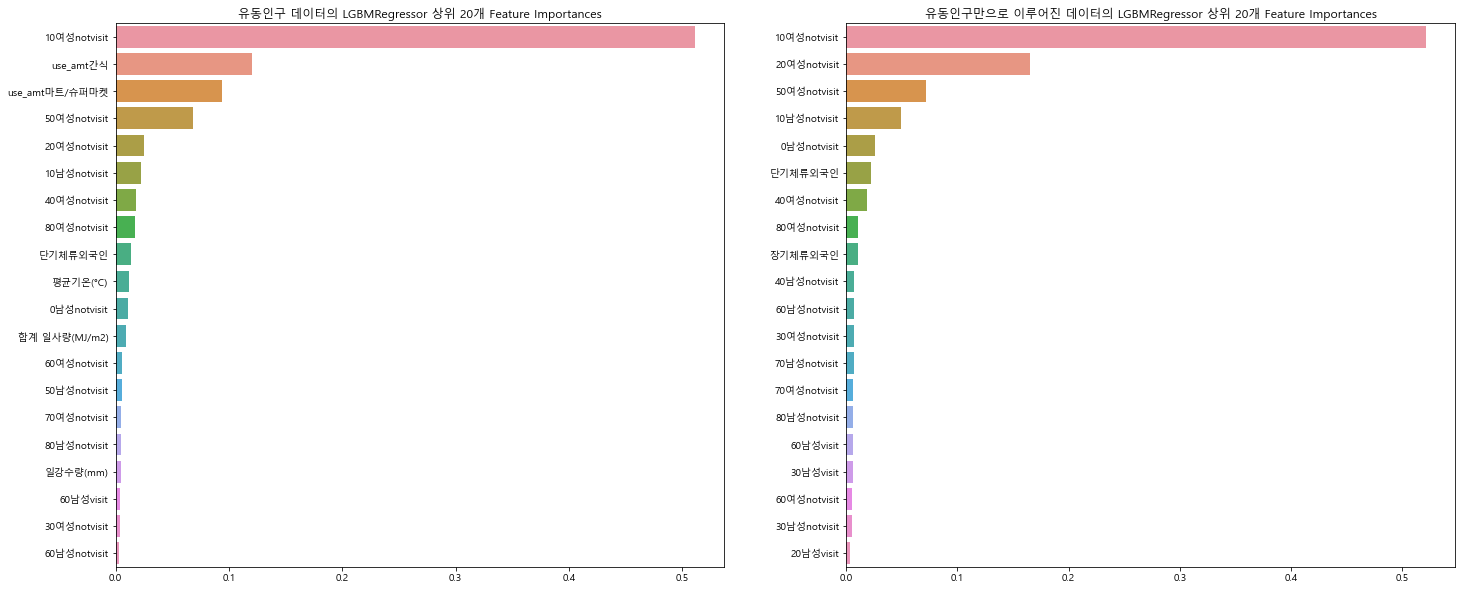

Wall time: 3.91 s


In [38]:
%%time
train_to_plot('LGBM', params, df_float_list, ncols=2)

In [71]:
df_float181 = df_float[(df_float['base_date']<'2018-07')]
df_float182 = df_float[(df_float['base_date']>'2018-07') & (df_float['base_date']<'2019')]
df_float191 = df_float[(df_float['base_date']>'2019') & (df_float['base_date']<'2019-07')]
df_float192 = df_float[(df_float['base_date']>'2019-07') & (df_float['base_date']<'2020')]
df_float201 = df_float[(df_float['base_date']>'2020') & (df_float['base_date']<'2020-07')]
df_float202 = df_float[(df_float['base_date']>'2020-07') & (df_float['base_date']<'2021')]
df_float211 = df_float[(df_float['base_date']>'2021')]

In [74]:
df_float_year_list = [(df_float181, '18년 상반기 유동인구 데이터'), (df_float182, '18년 하반기 유동인구 데이터'), (df_float191, '19년 상반기 유동인구 데이터'), (df_float192, '19년 하반기 유동인구 데이터'),
          (df_float201, '20년 상반기 유동인구 데이터'), (df_float202, '20년 하반기 유동인구 데이터'), (df_float201, '21년 상반기 유동인구 데이터')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 18년 상반기 유동인구 데이터 ###
RMSE : 254169.6294
MAE : 157185.6301
R2 : 0.9852

### 18년 하반기 유동인구 데이터 ###
RMSE : 248888.0999
MAE : 152228.6659
R2 : 0.9875

### 19년 상반기 유동인구 데이터 ###
RMSE : 248358.7952
MAE : 164113.2349
R2 : 0.9845

### 19년 하반기 유동인구 데이터 ###
RMSE : 291018.1839
MAE : 170705.3088
R2 : 0.9770

### 20년 상반기 유동인구 데이터 ###
RMSE : 328684.4428
MAE : 183383.2989
R2 : 0.9675

### 20년 하반기 유동인구 데이터 ###
RMSE : 276916.1074
MAE : 179011.3861
R2 : 0.9795

### 21년 상반기 유동인구 데이터 ###
RMSE : 328684.4428
MAE : 183383.2989
R2 : 0.9675



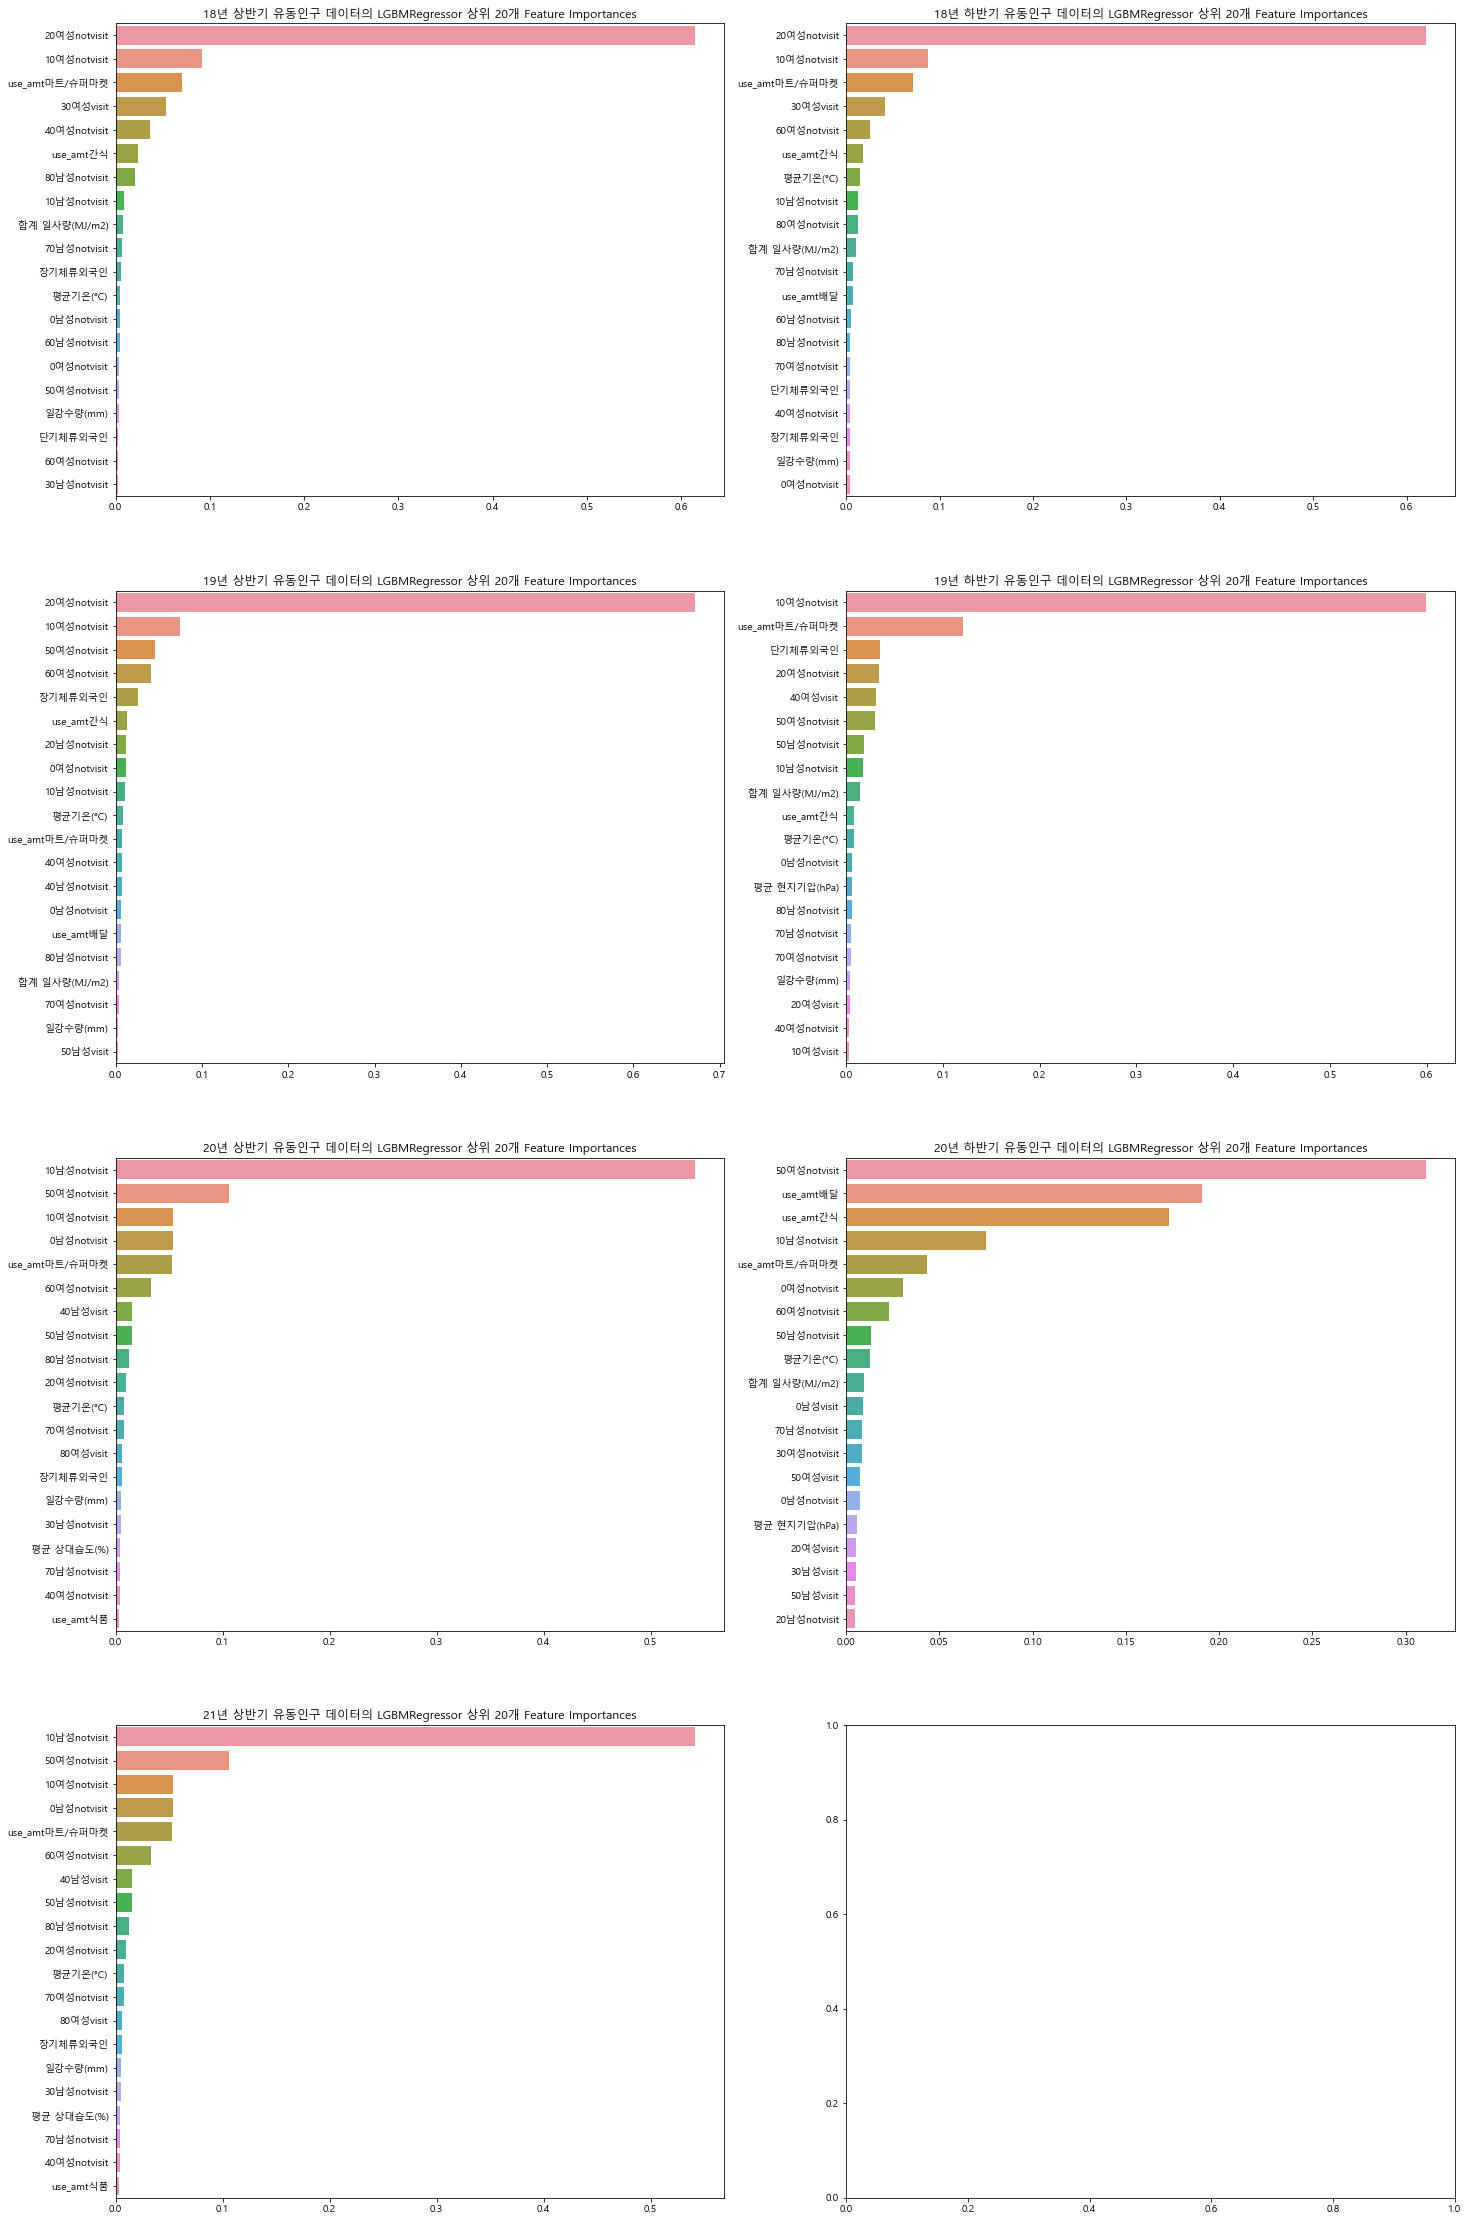

Wall time: 9.2 s


In [75]:
%%time
train_to_plot('LGBM', params, df_float_year_list, ncols=2)

# 상호작용

In [49]:
df_all.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [50]:
df_i1 = df_all.copy()
df_i1.insert(42, '배달식품', df_i1['use_amt배달'] * df_i1['use_amt식품'])
df_i1.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '배달식품', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [51]:
df_i2 = df_all.copy()
df_i2.insert(42, '배달간식', df_i1['use_amt배달'] * df_i1['use_amt간식'])
df_i2.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '배달간식', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [52]:
df_i3 = df_all.copy()
df_i3.insert(42, '배달마트', df_i1['use_amt배달'] * df_i1['use_amt마트/슈퍼마켓'])
df_i3.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '배달마트', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [53]:
df_i4 = df_all.copy()
df_i4.insert(42, '식품간식', df_i1['use_amt식품'] * df_i1['use_amt간식'])
df_i4.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '식품간식', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [54]:
df_i5 = df_all.copy()
df_i5.insert(42, '식품마트', df_i1['use_amt식품'] * df_i1['use_amt마트/슈퍼마켓'])
df_i5.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '식품마트', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [55]:
df_i6 = df_all.copy()
df_i6.insert(42, '마트간식', df_i1['use_amt마트/슈퍼마켓'] * df_i1['use_amt간식'])
df_i6.columns

Index(['base_date', 'city', 'emd_nm', '0여성notvisit', '0여성visit', '0남성notvisit',
       '0남성visit', '10여성notvisit', '10여성visit', '10남성notvisit', '10남성visit',
       '20여성notvisit', '20여성visit', '20남성notvisit', '20남성visit',
       '30여성notvisit', '30여성visit', '30남성notvisit', '30남성visit',
       '40여성notvisit', '40여성visit', '40남성notvisit', '40남성visit',
       '50여성notvisit', '50여성visit', '50남성notvisit', '50남성visit',
       '60여성notvisit', '60여성visit', '60남성notvisit', '60남성visit',
       '70여성notvisit', '70여성visit', '70남성notvisit', '70남성visit',
       '80여성notvisit', '80여성visit', '80남성notvisit', '80남성visit', '장기체류외국인',
       '단기체류외국인', 'dayoff', '마트간식', 'use_amt배달', 'use_amt식품', 'use_amt농축수산물',
       'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)',
       '평균 현지기압(hPa)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)', '평균 전운량(1/10)',
       '내국인거주남성', '외국인거주남성', '내국인거주여성', '외국인거주여성', '배출량'],
      dtype='object')

In [46]:
df_inter_list = [(df_i1, '배달*식품'), (df_i2, '배달*간식'), (df_i3, '배달*마트'), 
                (df_i4, '식품*간식'), (df_i5, '식품*마트'), (df_i6, '마트*간식')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 배달*식품 ###
RMSE : 271672.9145
MAE : 169315.2665
R2 : 0.9806

### 배달*간식 ###
RMSE : 269219.4412
MAE : 167492.9422
R2 : 0.9810

### 배달*마트 ###
RMSE : 265731.3183
MAE : 166872.6392
R2 : 0.9815

### 식품*간식 ###
RMSE : 270554.1949
MAE : 168916.1118
R2 : 0.9808

### 식품*마트 ###
RMSE : 268851.5202
MAE : 169297.6535
R2 : 0.9810

### 마트*간식 ###
RMSE : 269568.5838
MAE : 169484.7786
R2 : 0.9809



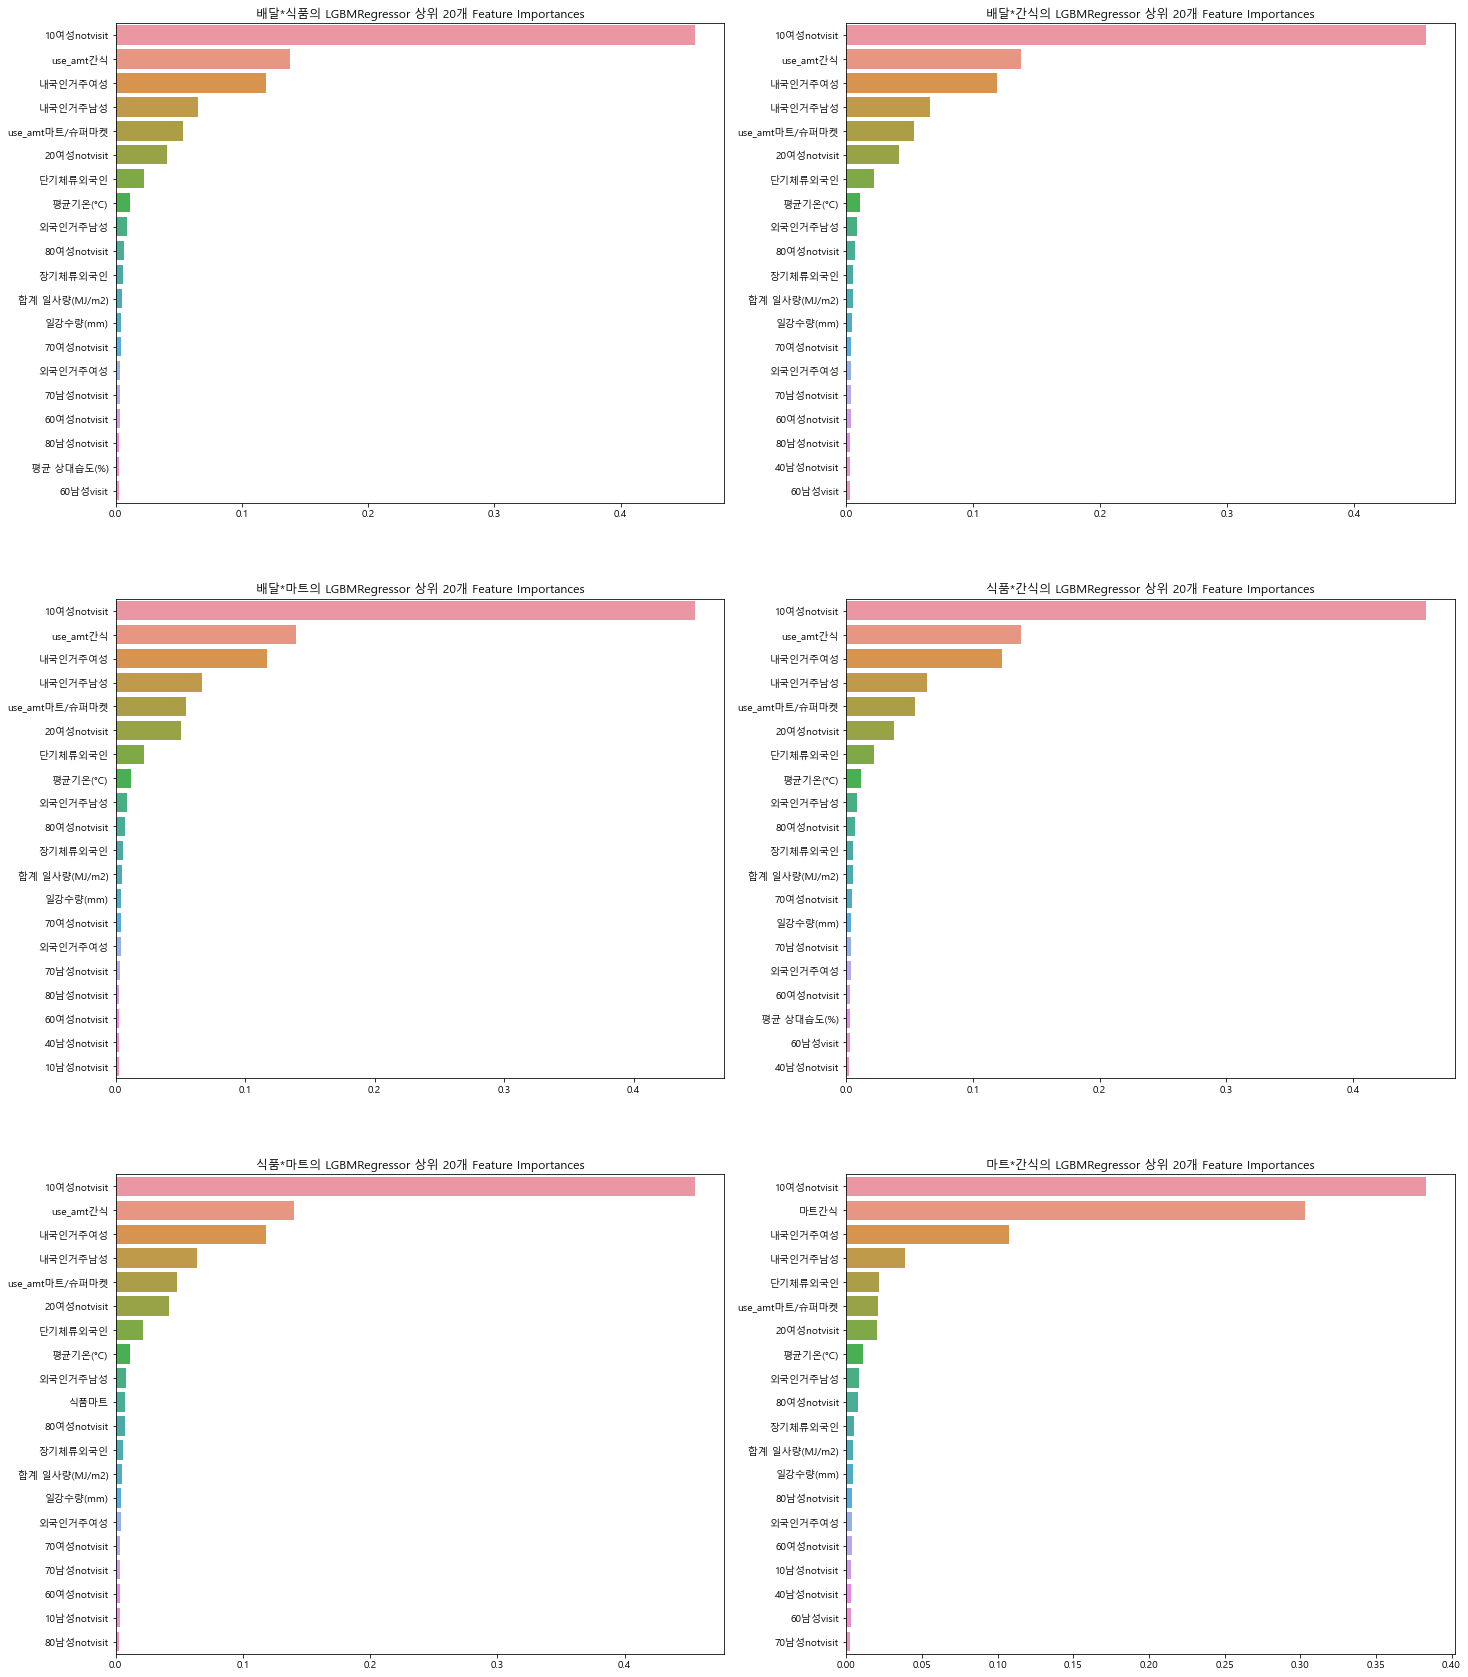

Wall time: 14.2 s


In [47]:
%%time
train_to_plot('LGBM', params, df_inter_list, ncols=2)

In [60]:
df_i1_nofloat = df_i1.drop(columns=df_i1.iloc[:, 3:41].columns)
df_i1_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '배달식품', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [61]:
df_i2_nofloat = df_i2.drop(columns=df_i2.iloc[:, 3:41].columns)
df_i2_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '배달간식', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [62]:
df_i3_nofloat = df_i3.drop(columns=df_i3.iloc[:, 3:41].columns)
df_i3_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '배달마트', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [63]:
df_i4_nofloat = df_i4.drop(columns=df_i4.iloc[:, 3:41].columns)
df_i4_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '식품간식', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [64]:
df_i5_nofloat = df_i5.drop(columns=df_i5.iloc[:, 3:41].columns)
df_i5_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '식품마트', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [65]:
df_i6_nofloat = df_i6.drop(columns=df_i6.iloc[:, 3:41].columns)
df_i6_nofloat.columns

Index(['base_date', 'city', 'emd_nm', 'dayoff', '마트간식', 'use_amt배달',
       'use_amt식품', 'use_amt농축수산물', 'use_amt마트/슈퍼마켓', 'use_amt간식', '평균기온(°C)',
       '일강수량(mm)', '평균 상대습도(%)', '평균 현지기압(hPa)', '합계 일사량(MJ/m2)',
       '일 최심신적설(cm)', '평균 전운량(1/10)', '내국인거주남성', '외국인거주남성', '내국인거주여성',
       '외국인거주여성', '배출량'],
      dtype='object')

In [66]:
df_inter_nofloat_list = [(df_i1_nofloat, '배달*식품'), (df_i2_nofloat, '배달*간식'), (df_i3_nofloat, '배달*마트'), 
                (df_i4_nofloat, '식품*간식'), (df_i5_nofloat, '식품*마트'), (df_i6_nofloat, '마트*간식')]
params = {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_weight': 0.001, 'subsample': 0.6, 'random_state':42, 'n_jobs':-1, 'n_estimators':1000, 'importance_type':'gain'}

### 배달*식품 ###
RMSE : 259256.4457
MAE : 164965.2229
R2 : 0.9824

### 배달*간식 ###
RMSE : 255469.3782
MAE : 163379.3149
R2 : 0.9829

### 배달*마트 ###
RMSE : 257167.5175
MAE : 164121.0550
R2 : 0.9826

### 식품*간식 ###
RMSE : 256933.9152
MAE : 164315.1735
R2 : 0.9827

### 식품*마트 ###
RMSE : 261425.2879
MAE : 166672.5808
R2 : 0.9821

### 마트*간식 ###
RMSE : 259724.5680
MAE : 164959.0493
R2 : 0.9823



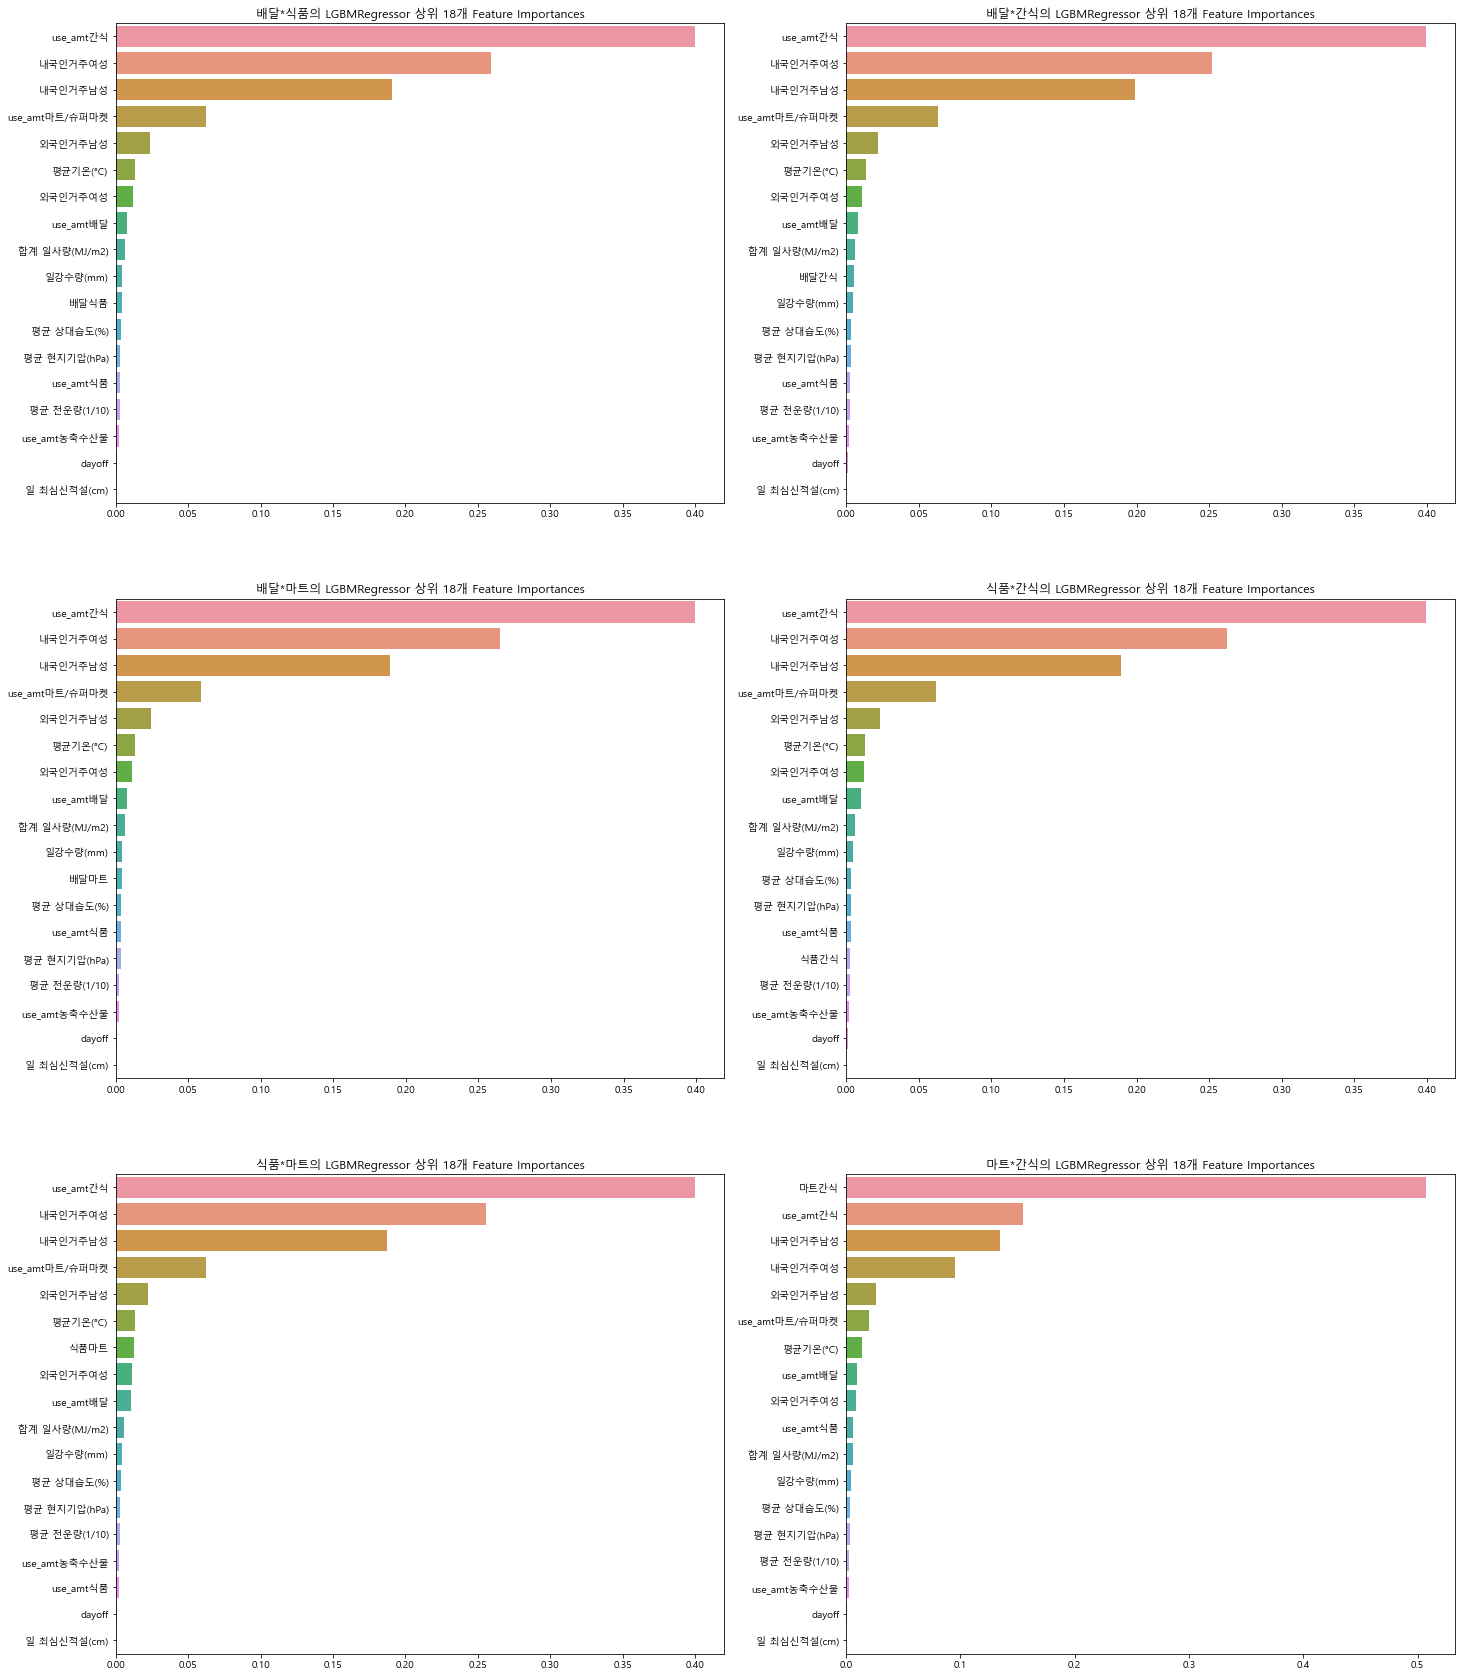

Wall time: 8.78 s


In [67]:
%%time
train_to_plot('LGBM', params, df_inter_nofloat_list, ncols=2)